## Third Approach: Re-sampling with SMOTE

In this approach, we will use the **SMOTE (Synthetic Minority Over-sampling Technique)** algorithm to balance the dataset. SMOTE generates synthetic samples for the minority class to balance the dataset. First, we will oversample the minority class **Enrolled**, then we will train a model using the balanced dataset. Additionally, we will perform other experiments, such as oversampling the other minority class **Dropout** and undersampling the majority class **Graduated**.

The SMOTE algorithm is described in the following paper: [SMOTE: Synthetic Minority Over-sampling Technique](https://www.jair.org/index.php/jair/article/view/10302/24590). In this paper, the authors present the algorithm and demonstrate how this technique of oversampling the minority class is superior to traditional oversampling techniques, which simply duplicate the samples of the minority class.

Below is the pseudo-code for a two-class problem:

```julia
Algorithm SMOTE(T, N, k)
Input:
    T = Number of minority class samples
    N = Percentage of oversampling (SMOTE percentage)
    k = Number of nearest neighbors

Output:
    (N/100) * T synthetic minority class samples

1. If N is less than 100%, randomize the minority class samples, as only a random percentage of them will be SMOTEd.
2. If N < 100 then
    3. Randomize the T minority class samples
    4. T = (N / 100) * T
    5. N = 100
6. End if
7. N = (int)(N / 100) * T  (*The amount of SMOTE is assumed to be in integral multiples of 100.*)
8. k = Number of nearest neighbors
9. numattrs = Number of attributes
10. Sample[][]: Array for original minority class samples
11. newindex: Counter for number of synthetic samples, initialized to 0
12. Synthetic[][]: Array for synthetic samples

13. For i = 1 to T
    14. Compute k nearest neighbors for sample i, and save the indices in nnarray
    15. Populate(N, i, nnarray)
16. End for

Function Populate(N, i, nnarray):
17. While N > 0
    18. Choose a random number between 1 and k, call it nn. This step selects one of the k nearest neighbors of sample i.
    19. For each attribute (attr) from 1 to numattrs:
        20. Compute the difference: dif = Sample[nnarray[nn]][attr] - Sample[i][attr]
        21. Compute a random gap: gap = random number between 0 and 1
        22. Synthetic[newindex][attr] = Sample[i][attr] + gap * dif
    20. End for
    23. Increment newindex
    24. Decrement N
25. End while

26. Return synthetic samples
End of pseudo-code.
```


### Description of the used models

To be able to compare the results with the first and second approaches, we will use the same configuration of hyperparameters for the models:

- **ANN**:
  - Hidden layers: 1, number of neurons in the hidden layer: $[16, 32, 64]$.
  - Hidden layers: 2, number of neurons in the hidden layers $[(16, 16), (32, 16), (32, 32), (64, 32), (64, 64)]$.
- **Decision Tree**:
  - Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{None}\}$
- **SVM**:
  - Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
  - C $\in \{0.1, 1, 10\}$
- **KNN\***:
  - $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$

After training the models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


- Imbalanced-learn (revision): https://www.sciencedirect.com/science/article/pii/S0957417416307175?casa_token=lyglFt_Ye0YAAAAA:Apv_dixqX-GQm04rHLrN6wBhIRJHhxCFlqUS5WXXbuD-iJCO9FUBZ9VLAxgRDwUTKdpPTGgHIA
  - Aqui falan de SMOTE (tecnica para over-sampling), tecnicas de re-sampling híbridas e undersampling.
  - Tamén falan de que aplicando PCA e tecnicas de reducción da dimensionalidade se pode reducir o efecto negativo do desbalanceamento.
  - Tamén comentan que as técnicas de ensamblado se utilizan para estas situacións, pero me da que non vai poder ser aplicable ao noso caso (utilizan AdaBoost e esas vainas).
  - Por último, comentan que se poden utilizar técnicas para ponderar os erros. Guai se utilizamos unha rede neuronal, posto que so hai que cambiar a función de custo, pero implementa ti isto en SVM ou Decision Tree. É posible, de feito, hai formas e explicanse, pero implicaría cambiar o codigo drasticamente.
- Learning from imbalanced data (non o lin, pero creo que tamén describe técnicas de resampling): https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5128907


**Index**

- [Data loading](#Data-loading)
- [SMOTE experiments](#SMOTE-experiments)
- [Individual models](#Individual-models)
  - [ANN](#ANN)
  - [Decision Tree](#Decision-Tree)
  - [Support Vector Machine](#Support-Vector-Machine)
  - [K-Nearest Neighbors](#K-Nearest-Neighbors)
- [Ensemble model](#Ensemble-model)
  - [Majority voting](#Majority-voting)
  - [Weighted voting](#Weighted-voting)
  - [Naive Bayes](#Naive-Bayes)
  - [Stacking](#Stacking)


## Data loading


In [101]:
using DataFrames
using CSV
using Random
using Serialization

In [113]:
# Load custom functions from provided files
include("preprocessing.jl")
include("metrics.jl")
include("training.jl")
include("plotting.jl")

generateComparisonTable (generic function with 3 methods)

In [104]:
# Set the random seed for reproducibility
Random.seed!(42)

# Load the dataset
dataset_path = "dataset.csv"
data = CSV.read(dataset_path, DataFrame);

# Separate features and target
target_column = :Target
inputs = select(data, Not(target_column))
targets = data[!, target_column];

In [105]:
inputs = Float32.(Matrix(inputs))

# Define the number of folds for cross-validation and obtain the indices
Random.seed!(42)
k = 5
N = size(inputs, 1)
fold_indices = crossValidation(targets, k)
metrics_to_save = [:accuracy, :precision, :recall, :f1_score];

## SMOTE experiments

In the first approach we see that we detected some problems in some metrics because of the imbalance of the dataset. For example, for the ANN model, we get high values of mean accuracy and low values of mean F1-score. This happens because the precision and recall of the class `Enrolled` are very low.

<div style="display: flex; justify-content: center;">
<image src="plots/Approach1/ANN/accuracy_performance_bar.png" width="600"/>
<image src="plots/Approach1/ANN/f1_score_performance_bar.png" width="600"/>
</div>

To address this problem, we will use the SMOTE algorithm to balance the dataset. We will conduct 5 experiments:

- Oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 200%.
- Oversampling the minority class `Dropout` at 200% and oversampling the minority class `Enrolled` at 300%.
- Oversampling the minority class `Enrolled` at 200% and undersampling the majority class `Graduated` at 50%.

We are going to fix the number of nearest neighbors to 5.

To avoid retraining all the models multiple times, we will perform the experiments only with the base models: ANN, Decision Tree, SVM, and KNN, using the best hyperparameters identified in the first approach. Subsequently, we will train the models in the same manner as in the first approach, but with the balanced dataset that yielded the best results.


In [106]:
target_column = :Target
println("\nClass Distribution:")
println(combine(groupby(data, target_column), nrow => :Count))


Class Distribution:
3×2 DataFrame
 Row │ Target    Count 
     │ String15  Int64 
─────┼─────────────────
   1 │ Dropout    1421
   2 │ Graduate   2209
   3 │ Enrolled    794


In [107]:
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50)
]
k = 5

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for (i, smote_percentage) in enumerate(smote_percentages)
      println("\nSmote percentages: ", smote_percentage)
      balanced_inputs, balanced_targets = smote(inputs, targets, smote_percentage, k)
      println("Number of instances: ", size(balanced_targets)[1])
      println("Elements of class Dropout: ", sum(balanced_targets .== "Dropout"))
      println("Elements of class Graduate: ", sum(balanced_targets .== "Graduate"))
      println("Elements of class Enrolled: ", sum(balanced_targets .== "Enrolled"))
    end
  end
end


Smote percentages: Dict("Enrolled" => 200)
Number of instances: 5218
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300)
Number of instances: 6012
Elements of class Dropout: 1421
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Dropout" => 200)
Number of instances: 6639
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 1588

Smote percentages: Dict("Enrolled" => 300, "Dropout" => 200)
Number of instances: 7433
Elements of class Dropout: 2842
Elements of class Graduate: 2209
Elements of class Enrolled: 2382

Smote percentages: Dict("Enrolled" => 200, "Graduate" => 50)
Number of instances: 4113
Elements of class Dropout: 1421
Elements of class Graduate: 1104
Elements of class Enrolled: 1588


In [135]:
# Best configurations
topology = [64, 23]
topology_scikit_ann = [64]
max_depth = 5
n_neighbors = 5
kernel = "linear"
C = 10

# ANN
hyperparameters_ann = Dict(
  "topology" => topology,
  "learningRate" => 0.01,
  "maxEpochs" => 100,
  "repetitionsTraining" => 10,
  "validationRatio" => 0.15,
  "maxEpochsVal" => 10,
  "minLoss" => 0.0001
)

# scikitANN
hyperparameters_scikit_ann = Dict(
  :hidden_layer_sizes => topology_scikit_ann,
  :learning_rate_init => 0.01,
  :max_iter => 100,
  :early_stopping => true,
  :tol => 0,
  :validation_fraction => 0.15,
  :n_iter_no_change => 10,
  :epsilon => 0.0001,
  :repetitionsTraining => 10
)

# DT
hyperparameters_dt = Dict(
  :max_depth => max_depth,
  :criterion => "gini",
  :min_samples_split => 2,
)

# SVM
hyperparameters_svm = Dict(
  :kernel => kernel,
  :C => C,
  :gamma => "auto",
  :probability => true,
)

# KNN
hyperparameters_knn = Dict(
  :n_neighbors => n_neighbors,
  :weights => "uniform",
  :metric => "euclidean",
)

# Define the hyperparameters for smote
k = 5
smote_percentages = [
  Dict("Enrolled" => 200),
  Dict("Enrolled" => 300),
  Dict("Enrolled" => 200, "Dropout" => 200),
  Dict("Enrolled" => 300, "Dropout" => 200),
  Dict("Enrolled" => 200, "Graduate" => 50),
  Dict{String,Int}()
];

In [136]:
Random.seed!(42)

general_results_ann = []
class_results_ann = []
general_results_scikit_ann = []
class_results_scikit_ann = []
general_results_dt = []
class_results_dt = []
general_results_svm = []
class_results_svm = []
general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for smote_percentage in smote_percentages
      println("\nSmote percentage: ", smote_percentage)

      # ANN
      println("ANN")
      gr, cr = modelCrossValidation(
        :ANN,
        hyperparameters_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_ann, gr)
      push!(class_results_ann, cr)

      # Scikit ANN
      println("scikitANN")
      gr, cr = modelCrossValidation(
        :scikit_ANN,
        hyperparameters_scikit_ann,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )

      push!(general_results_scikit_ann, gr)
      push!(class_results_scikit_ann, cr)

      # DT
      println("DT")
      gr, cr = modelCrossValidation(
        :DT,
        hyperparameters_dt,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_dt, gr)
      push!(class_results_dt, cr)

      # SVM
      println("SVM")
      gr, cr = modelCrossValidation(
        :SVC,
        hyperparameters_svm,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_svm, gr)
      push!(class_results_svm, cr)

      # KNN
      println("KNN")
      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters_knn,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        applySmote=true,
        smotePercentages=smote_percentage,
        smoteNeighbors=k,
        verbose=false
      )
      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end


Smote percentage: Dict("Enrolled" => 200)
ANN
Mean accuracy: 0.49056 ± 0.02368
	Class 1: 0.39107 ± 0.0318
	Class 2: 0.45274 ± 0.01855
	Class 3: 0.77385 ± 0.04008
Mean precision: 0.17421 ± 0.02191
	Class 1: 0.22472 ± 0.02683
	Class 2: 0.18 ± 0.06023
	Class 3: 0.06776 ± 0.04136
Mean recall: 0.30883 ± 0.04023
	Class 1: 0.59641 ± 0.08809
	Class 2: 0.20299 ± 0.11894
	Class 3: 0.08879 ± 0.07805
Mean f1_score: 0.18965 ± 0.02364
	Class 1: 0.31054 ± 0.03548
	Class 2: 0.15917 ± 0.07458
	Class 3: 0.0582 ± 0.04275
scikitANN
Mean accuracy: 0.83289 ± 0.00401
	Class 1: 0.83711 ± 0.00938
	Class 2: 0.83841 ± 0.01352
	Class 3: 0.81779 ± 0.01072
Mean precision: 0.71427 ± 0.01612
	Class 1: 0.76253 ± 0.01964
	Class 2: 0.75645 ± 0.00918
	Class 3: 0.48206 ± 0.08856
Mean recall: 0.74666 ± 0.00721
	Class 1: 0.85395 ± 0.08334
	Class 2: 0.83251 ± 0.05065
	Class 3: 0.20878 ± 0.07033
Mean f1_score: 0.71517 ± 0.01011
	Class 1: 0.80217 ± 0.05097
	Class 2: 0.78983 ± 0.02609
	Class 3: 0.28282 ± 0.07466
DT
Mean accura

### Save the results and analysis


In [140]:
# Save the results
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_smote_results.jl"

parameters = Dict("Enrolled" => [200, 300, 200, 300, 200, 100], "Dropout" => [100, 100, 200, 200, 100, 100], "Graduate" => [100, 100, 100, 100, 50, 100])

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => parameters,
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => parameters,
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => parameters,
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => parameters,
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => parameters,
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [142]:
results_folder = "results/"
filename = results_folder * "3_smote_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end;

In [143]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/smote/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────────────────────────────┬──────────┬───────────┬──────────┬──────────┐
│                              Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────────────────────────────┼──────────┼───────────┼──────────┼──────────┤
│ Enrolled: 100, Graduate: 100, Dropout: 100 │  0.84126 │  0.758658 │ 0.762712 │ 0.749317 │
│ Enrolled: 300, Graduate: 100, Dropout: 100 │ 0.825002 │  0.718262 │ 0.737853 │ 0.696807 │
│ Enrolled: 200, Graduate: 100, Dropout: 100 │ 0.824399 │  0.705794 │ 0.738983 │ 0.695392 │
│ Enrolled: 300, Graduate: 100, Dropout: 200 │ 0.684748 │  0.614731 │ 0.538983 │ 0.438837 │
│ Enrolled: 200, Graduate: 100, Dropout: 200 │ 0.678765 │  0.629952 │ 0.538983 │  0.43019 │
│  Enrolled: 200, Graduate: 50, Dropout: 100 │ 0.555833 │  0.653669 │ 0.385311 │ 0.305201 │
└────────────────────────────────────────────┴──────────┴───────────┴──────────┴──────────┘
Result

Based on the results presented in the tables, the best SMOTE configuration involves oversampling the minority class, `Enrolled`, by 300%, while keeping the majority class, `Graduated`, and the other class, `Dropout`, unchanged. This conclusion is drawn from the mean F1-score, the metric of primary interest in this analysis.

However, it is important to highlight that, except for the KNN model, applying SMOTE tends to degrade the performance compared to the initial approach without balancing the dataset. This decline can be attributed to the synthetic samples generated by the SMOTE algorithm, which may introduce noise rather than meaningful information for balancing the dataset. This underscores a critical limitation of SMOTE: its effectiveness is highly dependent on the characteristics of the dataset and the specific models used.

Another noteworthy point is the dataset's high dimensionality, which may lead SMOTE to generate synthetic samples that fail to benefit the models. High dimensionality can obscure meaningful patterns and hinder the generation of useful synthetic data. As a potential improvement, applying feature selection techniques to reduce the number of attributes before applying SMOTE could lead to better outcomes. This refined approach will be explored in the next steps of the analysis.


## Individual models

Next, we will train the individual models with the best hyperparameters identified in the first approach, but using the balanced dataset that yielded the best results in the SMOTE experiments.

### ANN

We are going to use the our implementation for Artificial Neural Networks. To augment the robustness of the model, we will train each architecture 10 times with each fold of the cross-validation.

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [148]:
# Set the random seed for reproducibility
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_ann = []
class_results_ann = []

for topology in topologies
  hyperparameters = Dict(
    "topology" => topology,
    "learningRate" => 0.01,
    "maxEpochs" => 100,
    "repetitionsTraining" => 10,
    "validationRatio" => 0.15,
    "maxEpochsVal" => 10,
    "minLoss" => 0.0001
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_ann, gr)
  push!(class_results_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.69571 ± 0.18204
	Class 1: 0.71881 ± 0.19474
	Class 2: 0.67378 ± 0.19473
	Class 3: 0.71535 ± 0.12716
Mean precision: 0.54407 ± 0.2383
	Class 1: 0.587 ± 0.26759
	Class 2: 0.59238 ± 0.25377
	Class 3: 0.33277 ± 0.14331
Mean recall: 0.55397 ± 0.25725
	Class 1: 0.60642 ± 0.24957
	Class 2: 0.59786 ± 0.39513
	Class 3: 0.3379 ± 0.11117
Mean f1_score: 0.52234 ± 0.27642
	Class 1: 0.57639 ± 0.28565
	Class 2: 0.57025 ± 0.35296
	Class 3: 0.29224 ± 0.06037
Training ANN with topology: [32]
Mean accuracy: 0.55783 ± 0.15533
	Class 1: 0.55094 ± 0.17963
	Class 2: 0.53002 ± 0.16457
	Class 3: 0.64748 ± 0.10998
Mean precision: 0.36065 ± 0.21046
	Class 1: 0.34016 ± 0.23935
	Class 2: 0.40864 ± 0.21963
	Class 3: 0.26364 ± 0.14519
Mean recall: 0.36422 ± 0.21761
	Class 1: 0.45173 ± 0.22092
	Class 2: 0.30606 ± 0.33504
	Class 3: 0.36886 ± 0.12442
Mean f1_score: 0.30721 ± 0.23599
	Class 1: 0.36137 ± 0.24086
	Class 2: 0.29594 ± 0.30383
	Class 3: 0.2413 ± 0.06593
Train

## ScikitLearn ANN

We will use the MLPClassifier from ScikitLearn to train the ANN models. The hyperparameters used in the models are the same as in the previous ANN implementation:

We trained 8 models, 3 with one hidden layer and 5 with two hidden layers. The used topology for the hidden layers are:

- **One hidden layer**:
  - 16 neurons
  - 32 neurons
  - 64 neurons
- **Two hidden layers**:
  - (16, 16) neurons
  - (32, 16) neurons
  - (32, 32) neurons
  - (64, 32) neurons
  - (64, 64) neurons


In [147]:
# Set the random seed for reproducibility
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

topologies = [[16], [32], [64], [16, 16], [32, 16], [32, 32], [64, 32], [64, 64]]

general_results_scikit_ann = []
class_results_scikit_ann = []

for topology in topologies
  hyperparameters = Dict(
    :hidden_layer_sizes => topology,
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001,
    :repetitionsTraining => 10
  )

  println("Training ANN with topology: ", topology)

  gr, cr = modelCrossValidation(
    :scikit_ANN,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_scikit_ann, gr)
  push!(class_results_scikit_ann, cr)
end

Training ANN with topology: [16]
Mean accuracy: 0.83619 ± 0.00802
	Class 1: 0.84321 ± 0.01332
	Class 2: 0.84031 ± 0.01017
	Class 3: 0.81757 ± 0.01644
Mean precision: 0.72914 ± 0.0162
	Class 1: 0.78927 ± 0.0102
	Class 2: 0.75547 ± 0.0286
	Class 3: 0.50031 ± 0.09016
Mean recall: 0.75054 ± 0.013
	Class 1: 0.85407 ± 0.07203
	Class 2: 0.77936 ± 0.10627
	Class 3: 0.32407 ± 0.08207
Mean f1_score: 0.73274 ± 0.01287
	Class 1: 0.81845 ± 0.03188
	Class 2: 0.76285 ± 0.06769
	Class 3: 0.38928 ± 0.0834
Training ANN with topology: [32]
Mean accuracy: 0.8348 ± 0.00581
	Class 1: 0.83865 ± 0.01061
	Class 2: 0.83983 ± 0.01215
	Class 3: 0.81894 ± 0.0117
Mean precision: 0.72292 ± 0.01355
	Class 1: 0.77309 ± 0.01312
	Class 2: 0.75038 ± 0.02253
	Class 3: 0.50219 ± 0.06672
Mean recall: 0.74871 ± 0.00936
	Class 1: 0.86361 ± 0.06316
	Class 2: 0.78107 ± 0.08231
	Class 3: 0.28951 ± 0.05545
Mean f1_score: 0.72645 ± 0.01006
	Class 1: 0.81409 ± 0.03566
	Class 2: 0.76247 ± 0.05184
	Class 3: 0.36036 ± 0.05693
Training

### Decision Tree

The Decision Tree model will be trained with the following hyperparameters:

- Maximum depth of the tree $\in \{3, 5, 10, 15, 20, \text{nothing}\}$


In [145]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

max_depths = [3, 5, 10, 15, 20, nothing]

general_results_dt = []
class_results_dt = []

for max_depth in max_depths
  hyperparameters = Dict(
    :max_depth => max_depth,
    :criterion => "gini",
    :min_samples_split => 2,
  )

  println("Training DT model with max_depth: ", max_depth)

  gr, ct = modelCrossValidation(
    :DT,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false
  )

  push!(general_results_dt, gr)
  push!(class_results_dt, ct)
end

Training DT model with max_depth: 3
Mean accuracy: 0.82239 ± 0.00886
	Class 1: 0.82435 ± 0.03155
	Class 2: 0.8255 ± 0.0243
	Class 3: 0.81939 ± 0.02309
Mean precision: 0.73254 ± 0.01711
	Class 1: 0.793 ± 0.06498
	Class 2: 0.73257 ± 0.16399
	Class 3: 0.53936 ± 0.16781
Mean recall: 0.73462 ± 0.00832
	Class 1: 0.80915 ± 0.13539
	Class 2: 0.72364 ± 0.19998
	Class 3: 0.41 ± 0.18145
Mean f1_score: 0.72291 ± 0.01767
	Class 1: 0.79132 ± 0.04483
	Class 2: 0.71912 ± 0.15232
	Class 3: 0.45831 ± 0.17659
Training DT model with max_depth: 5
Mean accuracy: 0.8319 ± 0.00851
	Class 1: 0.83068 ± 0.03599
	Class 2: 0.84766 ± 0.02575
	Class 3: 0.82572 ± 0.00895
Mean precision: 0.74572 ± 0.01161
	Class 1: 0.78966 ± 0.07788
	Class 2: 0.82463 ± 0.06303
	Class 3: 0.52628 ± 0.04702
Mean recall: 0.75203 ± 0.01054
	Class 1: 0.85111 ± 0.15039
	Class 2: 0.78715 ± 0.13444
	Class 3: 0.316 ± 0.07442
Mean f1_score: 0.73354 ± 0.01571
	Class 1: 0.80672 ± 0.03615
	Class 2: 0.79598 ± 0.03953
	Class 3: 0.39045 ± 0.06055
Trai

### Support Vector Machine

The SVM model will be trained with all the possible combinations of the following hyperparameters:

- Kernel $\in \{\text{linear}, \text{poly}, \text{rbf}, \text{sigmoid}\}$
- C $\in \{0.1, 1, 10\}$


In [144]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

kernel_C = [
  ("linear", 0.1),
  ("linear", 1.0),
  ("linear", 10.0),
  ("poly", 0.1),
  ("poly", 1.0),
  ("poly", 10.0),
  ("rbf", 0.1),
  ("rbf", 1.0),
  ("rbf", 10.0),
  ("sigmoid", 0.1),
  ("sigmoid", 1.0),
  ("sigmoid", 10.0)
]

general_results_svm = []
class_results_svm = []

for (kernel, C) in kernel_C
  hyperparameters = Dict(
    :kernel => kernel,
    :C => C,
    :gamma => "auto",
    :probability => true,
  )

  println("Training SVM model with kernel: ", kernel, " and C: ", C)

  gr, cr = modelCrossValidation(
    :SVC,
    hyperparameters,
    inputs,
    targets,
    fold_indices;
    metricsToSave=metrics_to_save,
    normalizationType=:zeroMean,
    verbose=false,
    applySmote=true,
    smotePercentages=smotePercentages,
    smoteNeighbors=smoteNeighbors
  )

  push!(general_results_svm, gr)
  push!(class_results_svm, cr)
end

Training SVM model with kernel: linear and C: 0.1
Mean accuracy: 0.83932 ± 0.0053
	Class 1: 0.84313 ± 0.01768
	Class 2: 0.84381 ± 0.01783
	Class 3: 0.82437 ± 0.01836
Mean precision: 0.74213 ± 0.00892
	Class 1: 0.80216 ± 0.03251
	Class 2: 0.73873 ± 0.13465
	Class 3: 0.5517 ± 0.14857
Mean recall: 0.75565 ± 0.00773
	Class 1: 0.83672 ± 0.11782
	Class 2: 0.73351 ± 0.24722
	Class 3: 0.42062 ± 0.16478
Mean f1_score: 0.74222 ± 0.00703
	Class 1: 0.81364 ± 0.04237
	Class 2: 0.72924 ± 0.19089
	Class 3: 0.47555 ± 0.1599
Training SVM model with kernel: linear and C: 1.0
Mean accuracy: 0.83952 ± 0.00678
	Class 1: 0.84561 ± 0.0156
	Class 2: 0.8411 ± 0.01486
	Class 3: 0.8246 ± 0.01947
Mean precision: 0.74041 ± 0.01117
	Class 1: 0.80127 ± 0.02355
	Class 2: 0.73413 ± 0.12394
	Class 3: 0.55195 ± 0.14812
Mean recall: 0.75566 ± 0.01072
	Class 1: 0.84144 ± 0.1101
	Class 2: 0.73431 ± 0.24441
	Class 3: 0.41198 ± 0.17172
Mean f1_score: 0.74151 ± 0.00889
	Class 1: 0.81671 ± 0.04306
	Class 2: 0.7272 ± 0.18546
	C

### K-Nearest Neighbors

The KNN model will be trained with the following hyperparameters:

- $k \in \{1, 3, 5, 7, 9, 11, 13, 15\}$


In [146]:
# Set the random seed for reproducibility (smote is not deterministic)
Random.seed!(42)
# Best smote configuration
smotePercentages = Dict("Enrolled" => 300)
smoteNeighbors = 5

n_neighbors = [1, 3, 5, 7, 9, 11, 13, 15]

general_results_knn = []
class_results_knn = []

open("warnings.log", "w") do file
  redirect_stderr(file) do # redirect warnings associated with joblib
    for n in n_neighbors
      hyperparameters = Dict(
        :n_neighbors => n,
        :weights => "uniform",
        :metric => "euclidean",
      )

      println("Training KNN model with n_neighbors: ", n)

      gr, cr = modelCrossValidation(
        :KNN,
        hyperparameters,
        inputs,
        targets,
        fold_indices;
        metricsToSave=metrics_to_save,
        normalizationType=:zeroMean,
        verbose=false,
        applySmote=true,
        smotePercentages=smotePercentages,
        smoteNeighbors=smoteNeighbors
      )

      push!(general_results_knn, gr)
      push!(class_results_knn, cr)
    end
  end
end

Training KNN model with n_neighbors: 1
Mean accuracy: 0.77664 ± 0.01203
	Class 1: 0.79067 ± 0.02238
	Class 2: 0.77421 ± 0.02737
	Class 3: 0.77872 ± 0.03068
Mean precision: 0.66157 ± 0.01889
	Class 1: 0.72865 ± 0.01489
	Class 2: 0.57783 ± 0.20754
	Class 3: 0.51201 ± 0.18747
Mean recall: 0.6718 ± 0.01894
	Class 1: 0.71791 ± 0.09294
	Class 2: 0.58211 ± 0.26221
	Class 3: 0.47809 ± 0.23293
Mean f1_score: 0.66456 ± 0.01895
	Class 1: 0.72137 ± 0.05245
	Class 2: 0.57785 ± 0.23262
	Class 3: 0.49249 ± 0.20987
Training KNN model with n_neighbors: 3
Mean accuracy: 0.78536 ± 0.012
	Class 1: 0.78843 ± 0.02552
	Class 2: 0.79928 ± 0.02234
	Class 3: 0.77126 ± 0.02833
Mean precision: 0.67907 ± 0.0167
	Class 1: 0.74833 ± 0.01498
	Class 2: 0.67278 ± 0.14388
	Class 3: 0.44069 ± 0.18466
Mean recall: 0.67949 ± 0.02237
	Class 1: 0.74178 ± 0.0821
	Class 2: 0.62528 ± 0.16294
	Class 3: 0.46223 ± 0.21665
Mean f1_score: 0.67778 ± 0.01892
	Class 1: 0.74368 ± 0.04803
	Class 2: 0.64688 ± 0.15042
	Class 3: 0.45065 ± 0

### Save the results

The filename with the results of individual models of this first approach will be `3_individual_results.jl`.


In [149]:
results_folder = "results/"
if !isdir(results_folder)
  mkdir(results_folder)
end

filename = results_folder * "3_individual_results.jl"

# Separete the kernel and C values of the hyperparameter list for SVM
kernels = [item[1] for item in kernel_C]
C_values = [item[2] for item in kernel_C]

# Create a dictionary with the results of ANN, DT, SVM, and KNN
obj = Dict(
  :ANN => Dict(
    "num_trained_models" => length(general_results_ann),
    "parameters" => Dict(
      "topology" => topologies
    ),
    "general_results" => general_results_ann,
    "class_results" => class_results_ann
  ),
  :scikit_ANN => Dict(
    "num_trained_models" => length(general_results_scikit_ann),
    "parameters" => Dict(
      "hidden_layer_sizes" => topologies
    ),
    "general_results" => general_results_scikit_ann,
    "class_results" => class_results_scikit_ann
  ),
  :DT => Dict(
    "num_trained_models" => length(general_results_dt),
    "parameters" => Dict(
      "max_depth" => max_depths
    ),
    "general_results" => general_results_dt,
    "class_results" => class_results_dt
  ),
  :SVM => Dict(
    "num_trained_models" => length(general_results_svm),
    "parameters" => Dict(
      "kernel" => kernels,
      "C" => C_values
    ),
    "general_results" => general_results_svm,
    "class_results" => class_results_svm
  ),
  :KNN => Dict(
    "num_trained_models" => length(general_results_knn),
    "parameters" => Dict(
      "n_neighbors" => n_neighbors
    ),
    "general_results" => general_results_knn,
    "class_results" => class_results_knn
  )
)

# Save the results
open(filename, "w") do file
  serialize(file, obj)
end

In [167]:
results_folder = "results/"
filename = results_folder * "3_individual_results.jl"

# Load the results
loaded_obj = open(filename, "r") do file
  deserialize(file)
end;

#  As an example, print all the results again
for (algorithm, results) in loaded_obj
  println("Algorithm: ", algorithm)
  num_trained_models = results["num_trained_models"]
  println("Number of trained models: ", num_trained_models)
  general_results = results["general_results"]
  class_results = results["class_results"]
  parameters_names = keys(results["parameters"])
  parameters = results["parameters"]

  for i in 1:num_trained_models
    param_line = ""
    for param in parameters_names
      param_line *= param * ": " * string(parameters[param][i]) * ", "
    end
    println("\nModel ", i, ": ", param_line)
    gr = general_results[i]
    cr = class_results[i]
    for (metric, values) in gr
      println("Mean ", metric, ": ", round(mean(values), digits=5), " ± ", round(std(values), digits=5))
      for j in 1:length(cr)
        println("\tClass ", j, ": ", round(mean(cr[j][metric]), digits=5))
      end
    end
  end
end

Algorithm: DT
Number of trained models: 6

Model 1: max_depth: 3, 
Mean recall: 0.73462 ± 0.00832
	Class 1: 0.80915
	Class 2: 0.72364
	Class 3: 0.41
Mean f1_score: 0.72291 ± 0.01767
	Class 1: 0.79132
	Class 2: 0.71912
	Class 3: 0.45831
Mean precision: 0.73254 ± 0.01711
	Class 1: 0.793
	Class 2: 0.73257
	Class 3: 0.53936
Mean accuracy: 0.82239 ± 0.00886
	Class 1: 0.82435
	Class 2: 0.8255
	Class 3: 0.81939

Model 2: max_depth: 5, 
Mean recall: 0.75203 ± 0.01054
	Class 1: 0.85111
	Class 2: 0.78715
	Class 3: 0.316
Mean f1_score: 0.73354 ± 0.01571
	Class 1: 0.80672
	Class 2: 0.79598
	Class 3: 0.39045
Mean precision: 0.74572 ± 0.01161
	Class 1: 0.78966
	Class 2: 0.82463
	Class 3: 0.52628
Mean accuracy: 0.8319 ± 0.00851
	Class 1: 0.83068
	Class 2: 0.84766
	Class 3: 0.82572

Model 3: max_depth: 10, 
Mean recall: 0.73101 ± 0.01015
	Class 1: 0.83511
	Class 2: 0.67793
	Class 3: 0.47019
Mean f1_score: 0.72713 ± 0.00936
	Class 1: 0.8099
	Class 2: 0.69662
	Class 3: 0.48966
Mean precision: 0.72653 ± 

### Plots for base models


In [165]:
# Aggregate metrics
model_names, metrics, metric_means, metric_stds, metric_means_class, metric_stds_class, metric_maxes, metric_maxes_class = aggregateMetrics(loaded_obj, 3)
# Plot metrics for each algorithm
plotMetricsAlgorithm(loaded_obj, output_dir="./plots/Approach3/", ylim=(0.6, 0.9))
# Plot metrics for each class
plotMetricsAlgorithm(loaded_obj, 3, output_dir="./plots/Approach3/Classes", ylim=(0, 1))

Saved plots for DT and accuracy.
Saved plots for DT and precision.
Saved plots for DT and recall.
Saved plots for DT and f1_score.
Saved plots for KNN and accuracy.
Saved plots for KNN and precision.
Saved plots for KNN and recall.
Saved plots for KNN and f1_score.
Saved plots for SVM and accuracy.
Saved plots for SVM and precision.
Saved plots for SVM and recall.
Saved plots for SVM and f1_score.
Saved plots for scikit_ANN and accuracy.
Saved plots for scikit_ANN and precision.
Saved plots for scikit_ANN and recall.
Saved plots for scikit_ANN and f1_score.
Saved plots for ANN and accuracy.
Saved plots for ANN and precision.
Saved plots for ANN and recall.
Saved plots for ANN and f1_score.
Saved plots for DT and accuracy on Class 1.
Saved plots for DT and precision on Class 1.
Saved plots for DT and recall on Class 1.
Saved plots for DT and f1_score on Class 1.
Saved plots for DT and accuracy on Class 2.
Saved plots for DT and precision on Class 2.
Saved plots for DT and recall on Clas

In [ ]:
# Generate tables for each algorithm sorted by f1 score
generateAlgorithmTables(loaded_obj, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/")


Comparison of Hyperparameter Configurations for DT (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│       max_depth: 5 │  0.84126 │  0.758658 │ 0.762712 │ 0.749317 │
│      max_depth: 10 │  0.83099 │   0.74235 │ 0.740113 │ 0.740781 │
│       max_depth: 3 │ 0.827769 │  0.743737 │ 0.740113 │ 0.737836 │
│      max_depth: 20 │ 0.812289 │   0.71752 │ 0.716384 │  0.71693 │
│      max_depth: 15 │ 0.811716 │  0.715668 │ 0.715254 │ 0.715444 │
│ max_depth: nothing │  0.80447 │  0.710925 │ 0.707345 │ 0.709016 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT saved to ./tables/Approach3/.

Comparison of Hyperparameter Configurations for KNN (Sorted by F1_Score):
┌─────────────────┬──────────┬───────────┬──────────┬──────────┐
│   Configuration │ Accuracy │ Precision │   Recall │ F1-Scor

In [166]:
# Generate tables for each algorithm for each class sorted by f1 score
generateAlgorithmTables(loaded_obj, 3, sort_by=:F1_Score, rev=true, output_dir="./tables/Approach3/Classes")


Comparison of Hyperparameter Configurations for DT on Class 1 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuration │ Accuracy │ Precision │   Recall │ F1-Score │
├────────────────────┼──────────┼───────────┼──────────┼──────────┤
│      max_depth: 10 │ 0.821875 │  0.787944 │ 0.835105 │ 0.809902 │
│       max_depth: 5 │ 0.830678 │  0.789664 │ 0.851106 │ 0.806722 │
│       max_depth: 3 │ 0.824346 │  0.793005 │ 0.809152 │ 0.791315 │
│      max_depth: 20 │ 0.802432 │  0.762267 │ 0.760939 │ 0.761324 │
│      max_depth: 15 │ 0.810123 │  0.703576 │ 0.691736 │ 0.697128 │
│ max_depth: nothing │ 0.795651 │  0.684505 │ 0.681616 │ 0.682678 │
└────────────────────┴──────────┴───────────┴──────────┴──────────┘
Results for DT on Class 1 saved to ./tables/Approach3/Classes.

Comparison of Hyperparameter Configurations for DT on Class 2 (Sorted by F1_Score):
┌────────────────────┬──────────┬───────────┬──────────┬──────────┐
│      Configuratio

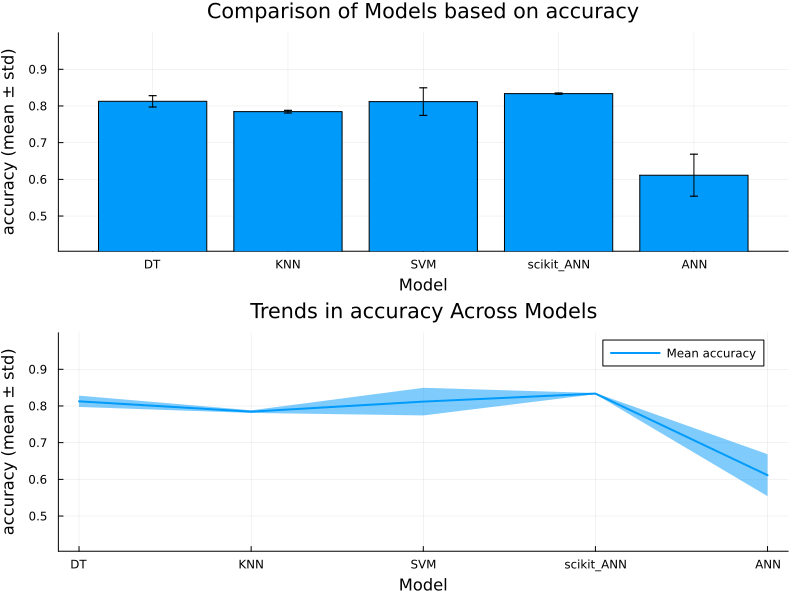

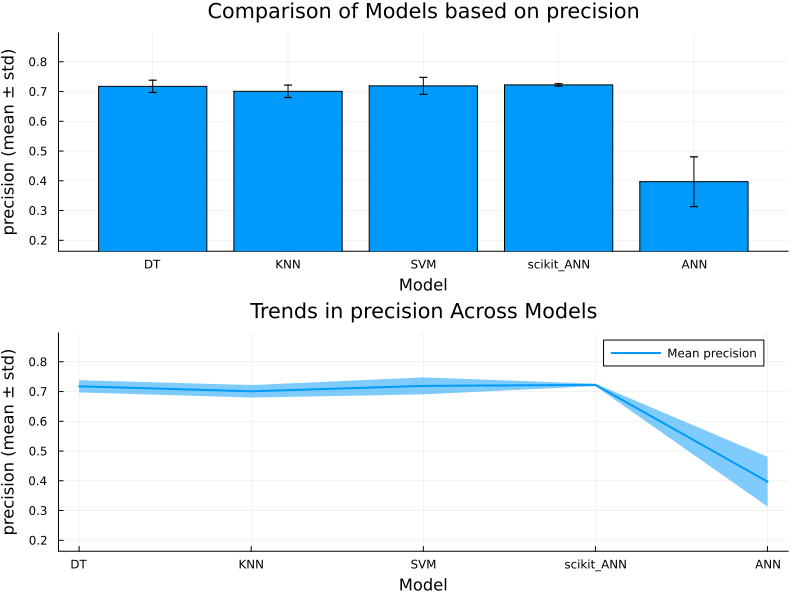

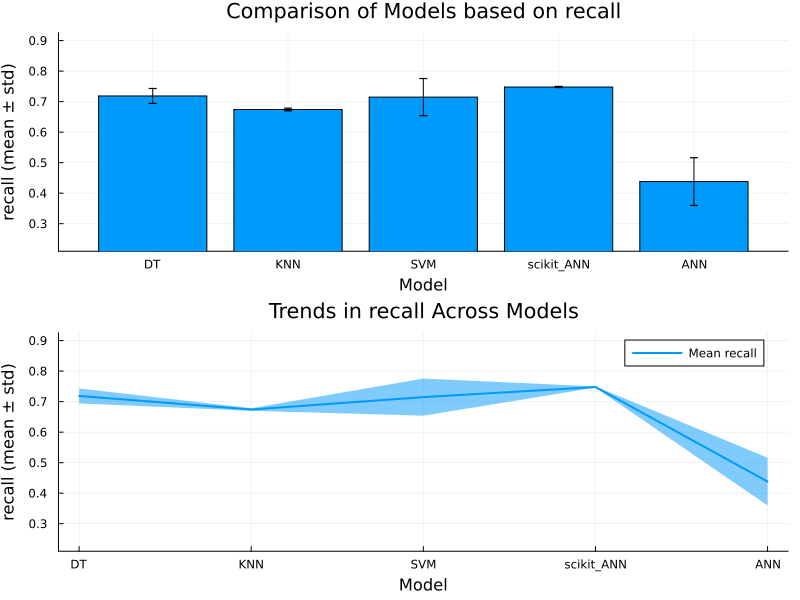

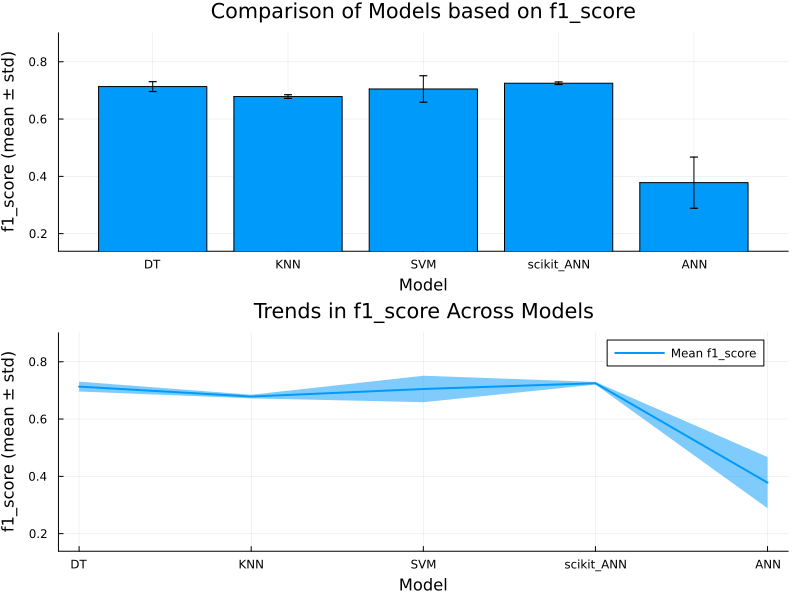

In [172]:
# Plot combined bar and line metrics
plotCombinedMetrics(model_names, metrics, metric_means, metric_stds, output_dir="./plots/Approach3/", show=true)

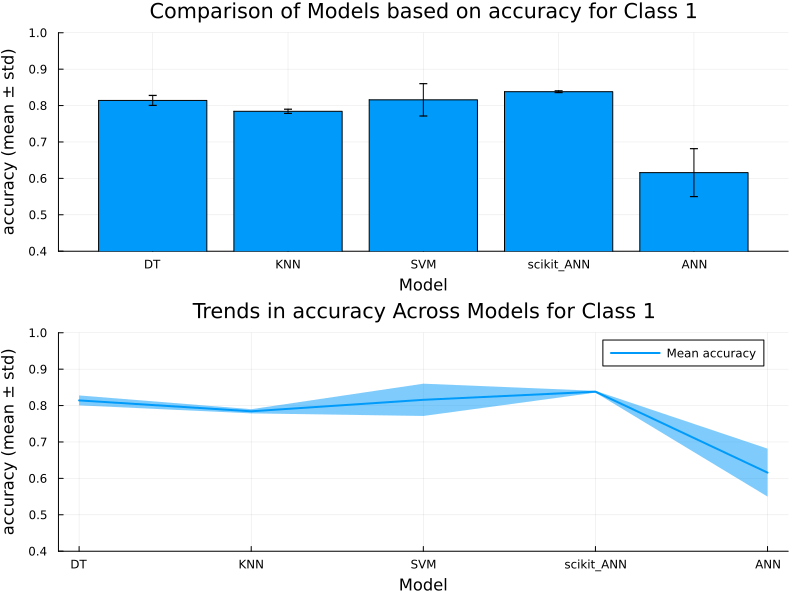

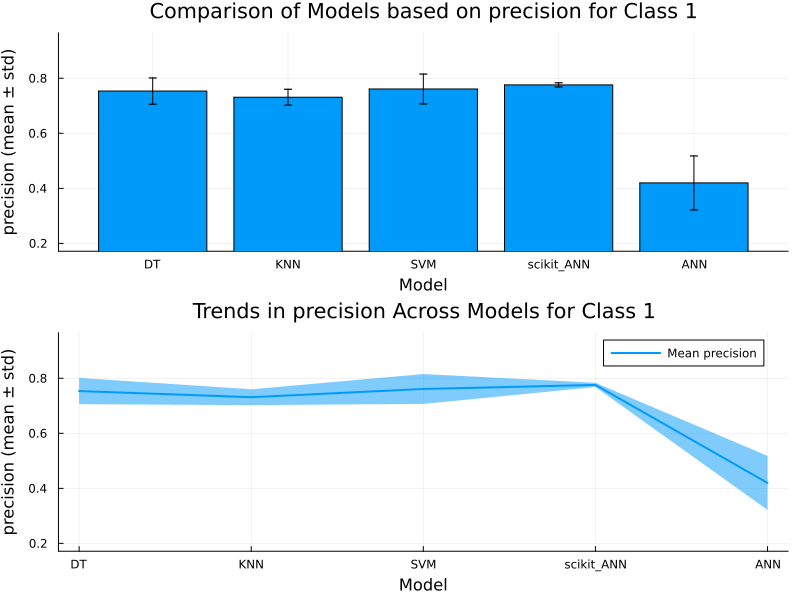

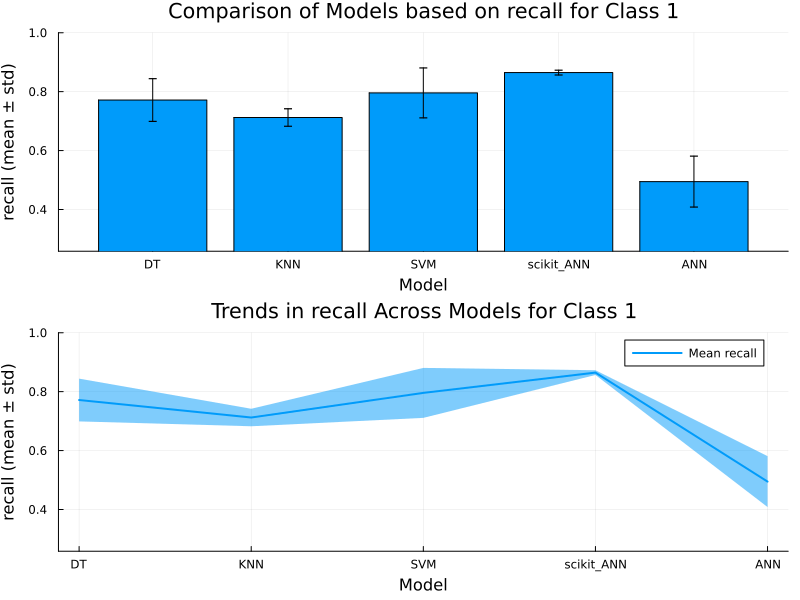

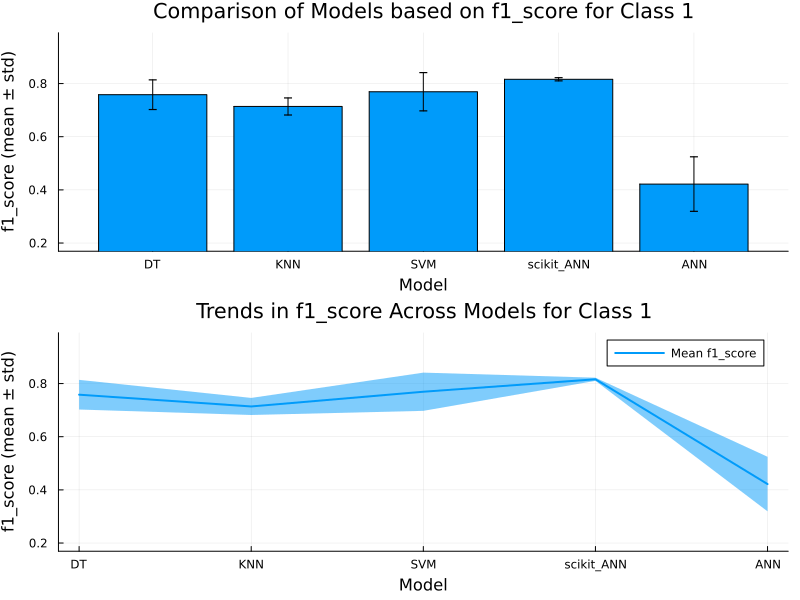

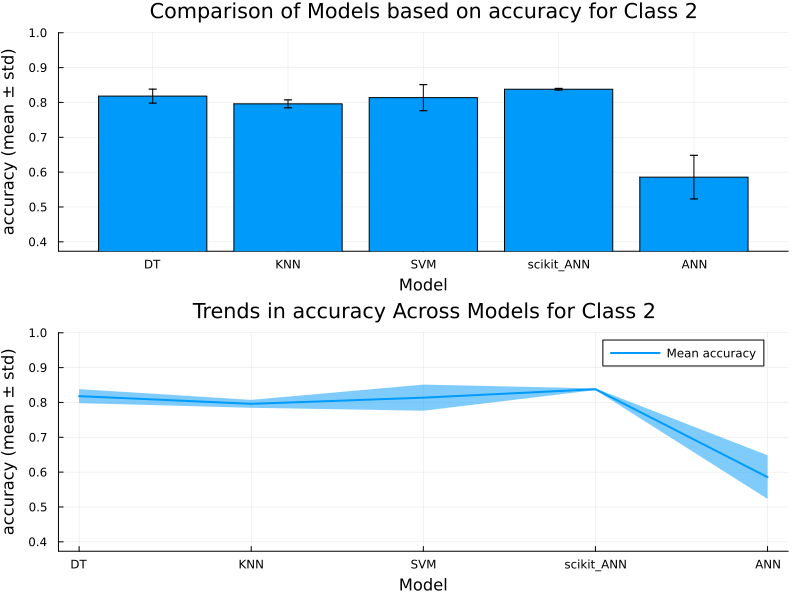

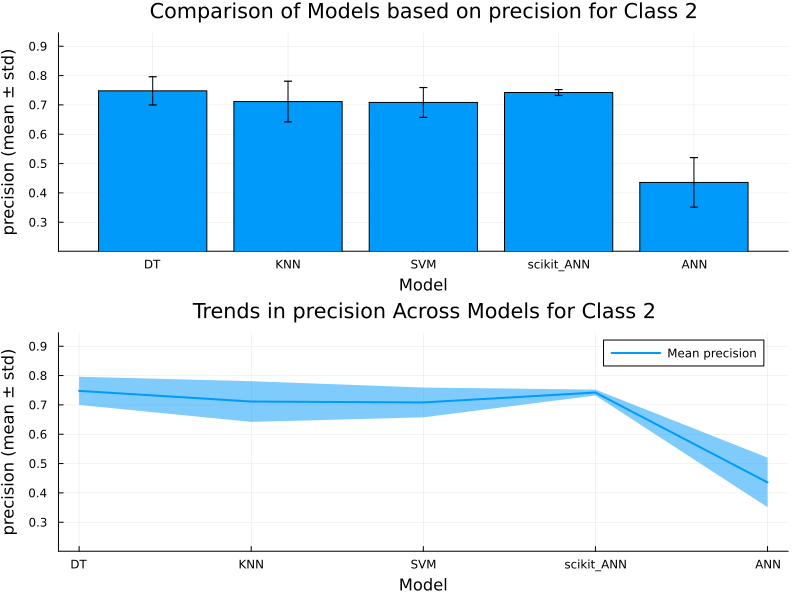

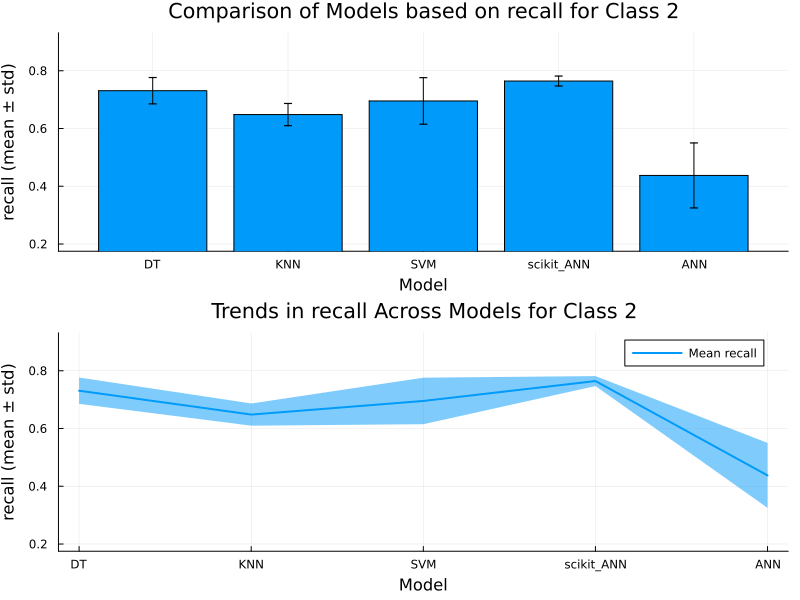

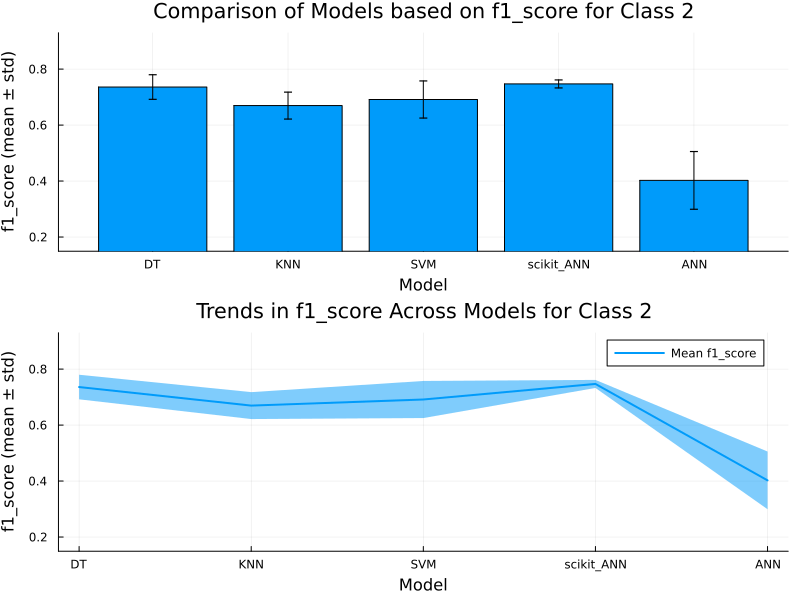

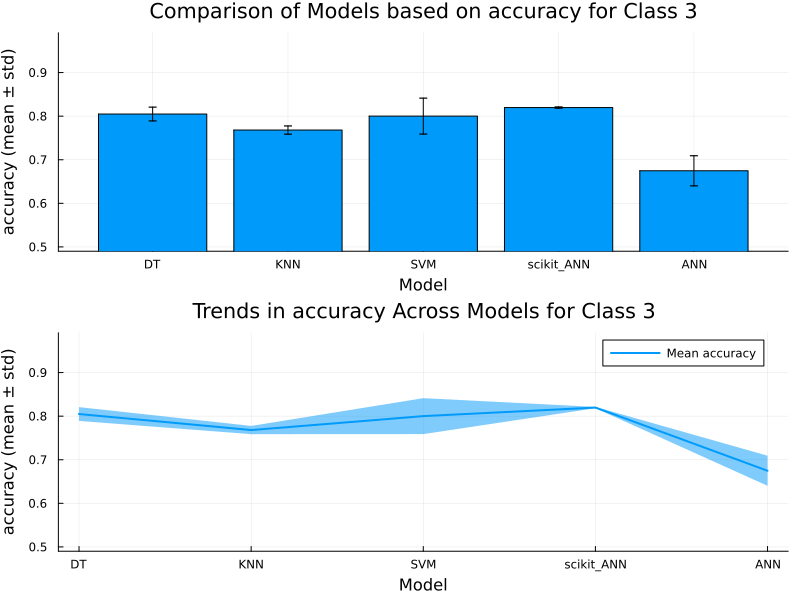

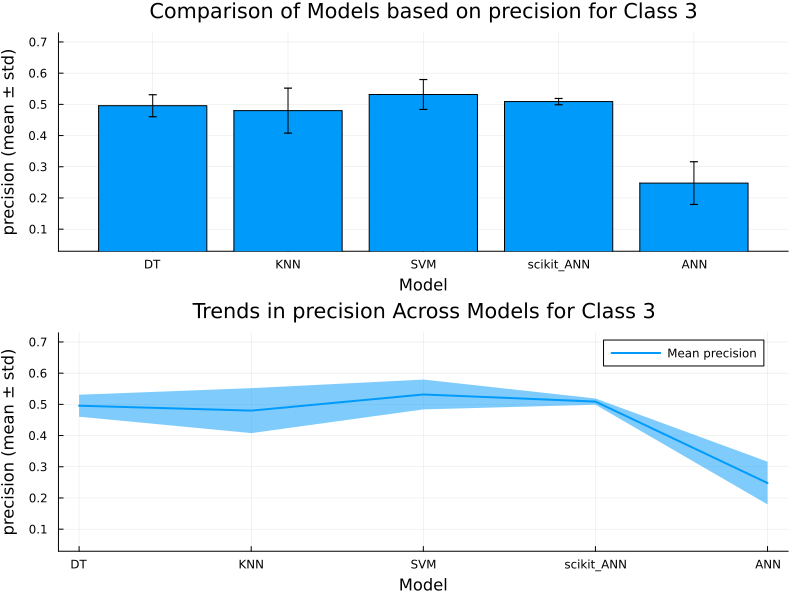

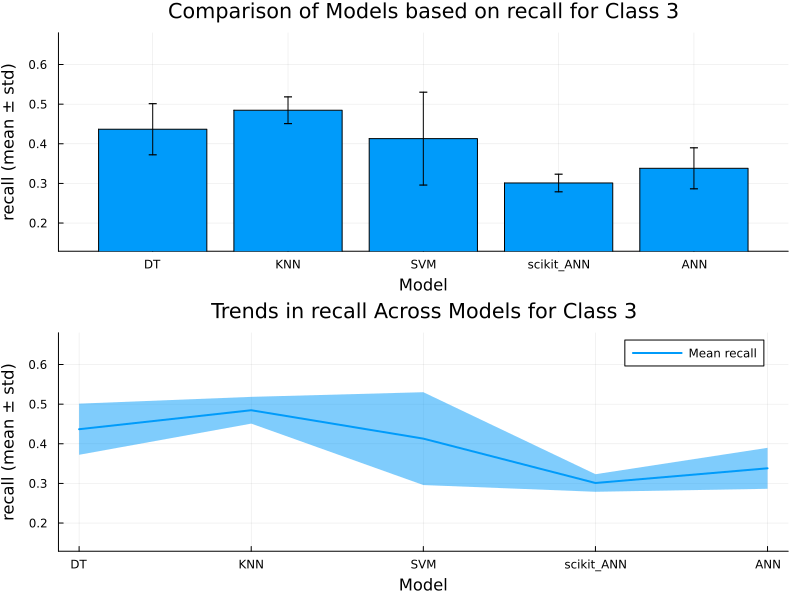

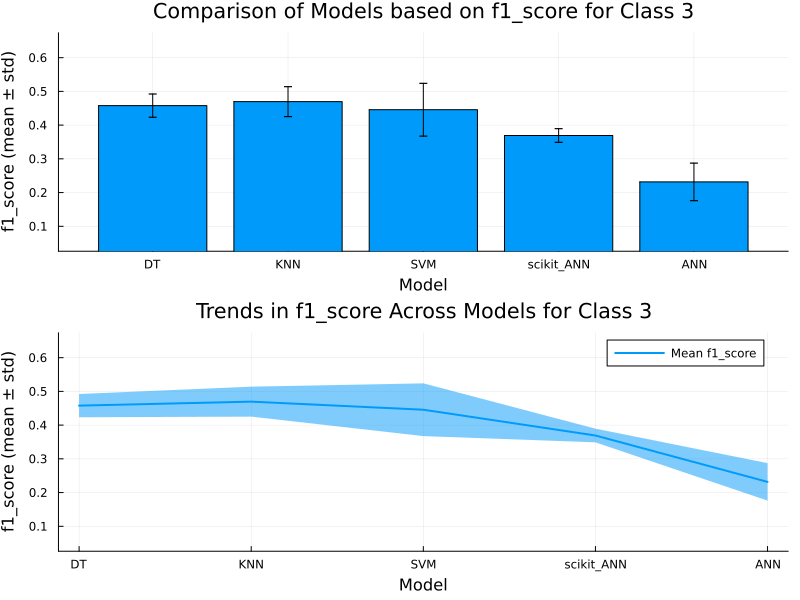

In [174]:
# Plot combined bar and line metrics per class
plotCombinedMetrics(model_names, 3, metrics, metric_means_class, metric_stds_class, output_dir="./plots/Approach3/Classes", show=true)

In [ ]:
# Generate and print the overall comparison table (selecting the best model for each metric)
generateComparisonTable(model_names, metrics, metric_maxes; sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.849 │     0.768 │  0.772 │    0.759 │
│ scikit_ANN │    0.845 │     0.745 │  0.764 │    0.746 │
│         DT │    0.841 │     0.759 │  0.763 │    0.749 │
│        ANN │    0.841 │     0.735 │  0.756 │    0.737 │
│        KNN │    0.813 │     0.741 │  0.716 │    0.719 │
└────────────┴──────────┴───────────┴────────┴──────────┘


In [ ]:
# Generate and print the overall comparison table by class (selecting the best model for each metric)
generateComparisonTable(model_names, 3, metrics, metric_maxes_class; sort_by=:accuracy, rev=true)


Comparison of Maximum Metrics Across Models for Class 1 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │    0.872 │     0.882 │  0.966 │    0.858 │
│         DT │    0.871 │     0.891 │  0.973 │     0.84 │
│        ANN │    0.871 │     0.812 │  0.824 │    0.805 │
│ scikit_ANN │     0.86 │     0.805 │  0.934 │    0.856 │
│        KNN │    0.829 │     0.912 │  0.853 │    0.811 │
└────────────┴──────────┴───────────┴────────┴──────────┘

Comparison of Maximum Metrics Across Models for Class 2 (Sorted by accuracy):
┌────────────┬──────────┬───────────┬────────┬──────────┐
│      Model │ Accuracy │ Precision │ Recall │ F1-Score │
├────────────┼──────────┼───────────┼────────┼──────────┤
│        SVM │     0.88 │     0.897 │  0.957 │    0.859 │
│         DT │     0.87 │     0.908 │  0.973 │    0.846 │
│ scikit_ANN │    0.859 │     

### Conclusions

In general, we see that applying SMOTE we do not outperform the results obtained in the first approach. Furthermore, we see that in this approach we obtained

Comparison table of the base models:

| Model      | Accuracy | Precision | Recall | F1-score |
| ---------- | -------- | --------- | ------ | -------- |
| SVM        | 0.855    | 0.769     | 0.78   | 0.767    |
| ANN        | 0.854    | 0.761     | 0.776  | 0.764    |
| scikit_ANN | 0.853    | 0.763     | 0.776  | 0.765    |
| DT         | 0.841    | 0.753     | 0.76   | 0.746    |
| KNN        | 0.815    | 0.721     | 0.732  | 0.705    |


| Model      | Accuracy | Precision | Recall | F1-score |
| ---------- | -------- | --------- | ------ | -------- |
| SVM        | 0.849    | 0.768     | 0.772  | 0.759    |
| scikit_ANN | 0.845    | 0.745     | 0.764  | 0.746    |
| DT         | 0.841    | 0.759     | 0.763  | 0.749    |
| ANN        | 0.841    | 0.735     | 0.756  | 0.737    |
| KNN        | 0.813    | 0.741     | 0.716  | 0.719    |


## Ensemble models

After training the individual models, we will train an ensemble model with the three best models. The method used to combine the models will be:

- **Majority voting**
- **Weighted voting**
- **Naive Bayes**
- **Stacking** (using a logistic regression as the meta-model)


In [ ]:
# Select the best models
estimators = [:ANN, :SVC, :DT]
hyperparameters = Vector{Dict}([
  Dict(
    :hidden_layer_sizes => (64, 32),
    :learning_rate_init => 0.01,
    :max_iter => 100,
    :early_stopping => true,
    :tol => 0,
    :validation_fraction => 0.15,
    :n_iter_no_change => 10,
    :epsilon => 0.0001
  ),
  Dict(
    :kernel => "linear",
    :C => 10.0,
    :gamma => "auto",
    :probability => true,
  ),
  Dict(
    :max_depth => 5,
    :criterion => "gini",
    :min_samples_split => 2,
  )])

# Define ensembles
ensembles = [
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
    )
  ),
  Dict(
    :type => :Voting,
    :hyperparameters => Dict(
      :voting => "soft",
      :weights => [0.5, 0.2, 0.3]
    )
  ),
  Dict(
    :type => :Stacking,
    :hyperparameters => Dict(
      :final_estimator => LogisticRegression()
    )
  )
]